# Tangles-CNN classifier validation script

In [1]:
# Load dependencies
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import json
import copy
import torch.cuda as cutorch
import timeit
import scipy.special
import sys
import sklearn.metrics

# Import modified wildcat
sys.path.append("wildcat.pytorch")
sys.path.append("../wildcat.pytorch")
sys.path.append("../")
import wildcat.models
from unet_wildcat import *

print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)
print("CUDA status: ", torch.cuda.is_available())
print("CUDA memory max alloc: %8.f MB" % (torch.cuda.max_memory_allocated() / 2.0**20))

/usr/lib/python3/dist-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: /usr/lib/python3/dist-packages/torchvision/image.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEE
  warn(f"Failed to load image Python extension: {e}")


PyTorch Version:  1.10.1+cu111
Torchvision Version:  0.11.2
CUDA status:  True
CUDA memory max alloc:        0 MB


/home/pauly2/cndr_histo/tanglethon-ipynb/wildcat.pytorch/wildcat/pooling.py:41: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if kmin > 0 and self.alpha is not 0:
/home/pauly2/cndr_histo/tanglethon-ipynb/wildcat.pytorch/wildcat/pooling.py:68: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if kmin > 0 and self.alpha is not 0:


## Validation Setup

In [8]:
# Set the experiment directory
# exp_dir = "/home/me/data/patches/exp01"
exp_dir = "/home/pauly2/cndr_histo/data/phf1/samples/exp02"

# Set how you refer to the objects and non-objects in this experiment
cname_obj="Object"
cname_bkg="Non-Object"

## Load Models

In [9]:
# Helper functions
%matplotlib inline
def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

In [10]:
# Dataloader with paths
class ImageFolderWithPaths(datasets.ImageFolder):
    """Custom dataset that includes image file paths. Extends
    torchvision.datasets.ImageFolder
    """

    # override the __getitem__ method. this is the method dataloader calls
    def __getitem__(self, index):
        # this is what ImageFolder normally returns 
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        # the image file path
        path = self.imgs[index][0]
        # make a new tuple that includes original and the path
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path

In [11]:
# Set main directories
data_dir = os.path.join(exp_dir, "patches")
model_dir = os.path.join(exp_dir, "models")

# Load model configuration from config.json
with open(os.path.join(model_dir, 'config.json'), 'r') as jfile:
    config = json.load(jfile)

# Set global properties
num_classes=config['num_classes']
input_size=config['wildcat_upsample']['input_size']
batch_size=config['wildcat_upsample']['batch_size']

In [12]:
# Create the model
model_ft=resnet50_wildcat_upsample(
    config['num_classes'], 
    pretrained=True, 
    kmax=config['wildcat_upsample']['kmax'], 
    kmin=config['wildcat_upsample']['kmin'],
    alpha=config['wildcat_upsample']['alpha'], 
    num_maps=config['wildcat_upsample']['num_maps'])

# Read model state
model_ft.load_state_dict(
    torch.load(os.path.join(model_dir, "wildcat_upsample.dat")))

# Send model to GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Sending loaded model to device: ", device)
model_ft.eval()
model_ft = model_ft.to(device)

Sending loaded model to device:  cuda:0


In [13]:
# Create a data loader
dt = transforms.Compose([
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
ds = ImageFolderWithPaths(os.path.join(data_dir, "test"), dt)
dl = torch.utils.data.DataLoader(ds, batch_size=batch_size, shuffle=True, num_workers=4)

## Run model on random batch

torch.Size([100, 3, 224, 224])

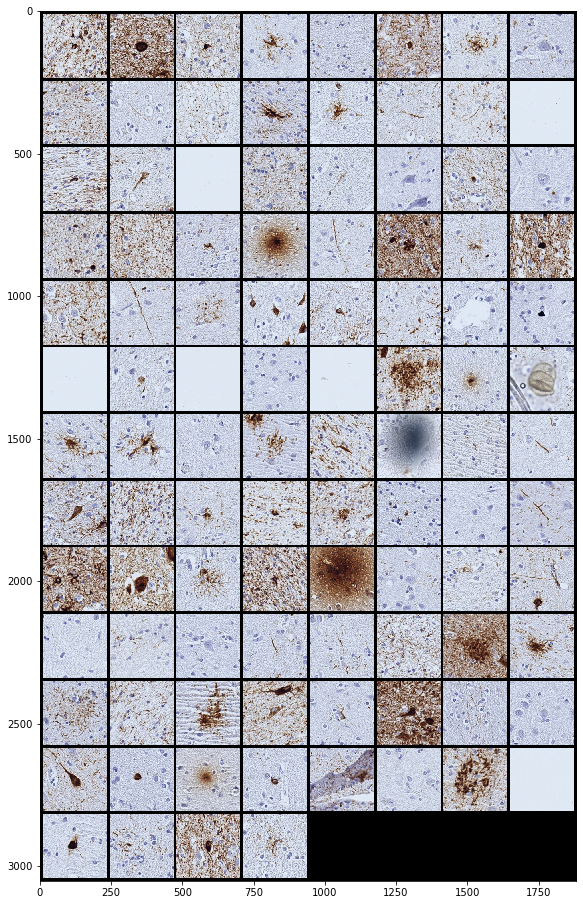

In [15]:
# Read a batch of data
img,label,paths=next(iter(dl))
plt.figure(figsize=(16,16))
show(torchvision.utils.make_grid(img, padding=10, nrow=8, normalize=True))
img.shape

In [19]:
# Evaluate model on this batch
model_ft.eval()
img_d = img.to(device)
label_d = label.to(device)
with torch.no_grad():
    outputs = model_ft(img_d)
_, preds = torch.max(outputs, 1)
(preds.cpu(),label)

RuntimeError: Legacy autograd function with non-static forward method is deprecated. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)

## Evaluate Model Accuracy on Test Set

In [10]:
# Perform full test set evaluation and save examples of errors
cm=np.zeros((num_classes,num_classes))
img_fp = torch.empty(0)
img_fn = torch.empty(0)
path_fp = []
path_fn = []
all_true = np.array([])
all_pred = np.array([])
with torch.no_grad():
    for img,label,paths in dl:
        img_d = img.to(device)
        label_d = label.to(device)
        outputs = model_ft(img_d)
        _, preds = torch.max(outputs, 1)
        all_true = np.append(all_true, label.numpy())
        scores = outputs.cpu().numpy()
        all_pred = np.append(all_pred, scores[:,1]-scores[:,0])
        for a in range(0,len(label)):
            l_pred = preds.cpu()[a].item()
            l_true = label[a].item()
            cm[l_pred,l_true]=cm[l_pred,l_true]+1
            if l_pred == 1 and l_true == 0:
                # False positive (non-tangle classified as tangle)
                img_fp = torch.cat((img_fp, img_d[a:a+1,:,:,:].cpu()))
                path_fp.append(paths[a]) 
            elif l_pred == 0 and l_true == 1:
                # False negative (tangle classified as non-tangle)
                img_fn = torch.cat((img_fn, img_d[a:a+1,:,:,:].cpu()))
                path_fn.append(paths[a]) 

# Print confusion matrix
cm

array([[2055.,    8.],
       [   9.,  362.]])

Accuracy of the model on the test set

In [11]:
(cm[0,0]+cm[1,1])/(cm[0,0]+cm[0,1]+cm[1,0]+cm[1,1])

0.9930156121610517

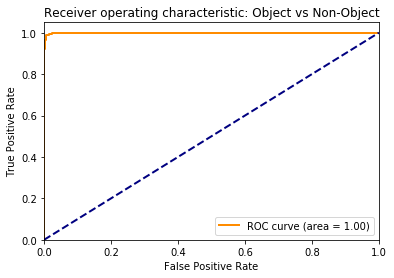

In [12]:
# Plot an ROC curve
fpr,tpr,_ = sklearn.metrics.roc_curve(all_true, all_pred)
auc = sklearn.metrics.auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic: %s vs %s' % (cname_obj, cname_bkg))
plt.legend(loc="lower right")
plt.show()

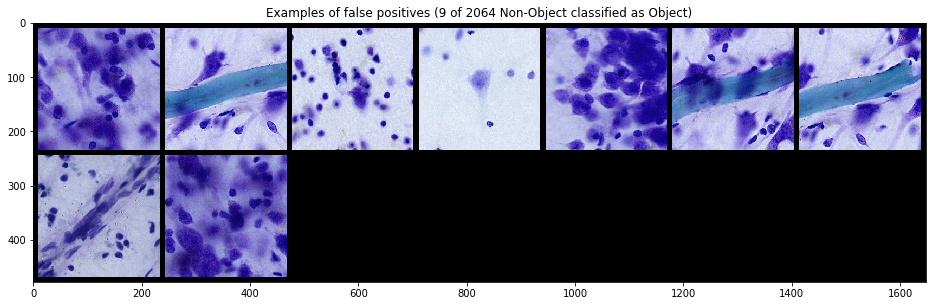

In [13]:
# Plot the false positives
sub_fp = np.random.choice(int(cm[1,0]),min(28,int(cm[1,0])),replace=False)
plt.figure(figsize=(16,16))
show(torchvision.utils.make_grid(img_fp[sub_fp,:,:,:], padding=10, nrow=7, normalize=True))
plt.title("Examples of false positives (%d of %d %s classified as %s)" % 
          (cm[1,0],cm[1,0]+cm[0,0],cname_bkg,cname_obj));
list(map(os.path.realpath, [ path_fp[i] for i in sub_fp]));

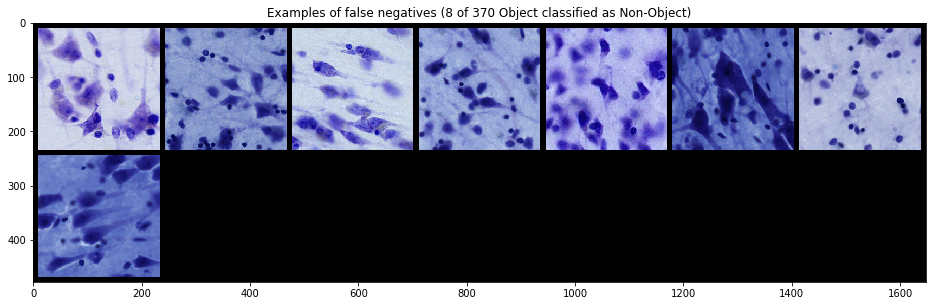

In [14]:
# Plot the false negatives
sub_fn = np.random.choice(int(cm[0,1]),min(28,int(cm[0,1])),replace=False)
plt.figure(figsize=(16,16))
show(torchvision.utils.make_grid(img_fn[sub_fn,:,:,:], padding=10, nrow=7, normalize=True))
plt.title("Examples of false negatives (%d of %d %s classified as %s)" % 
          (cm[0,1],cm[0,1]+cm[1,1],cname_obj,cname_bkg));
list(map(os.path.realpath, [ path_fn[i] for i in sub_fn]));

## Examine WildCat heat maps on random examples

array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

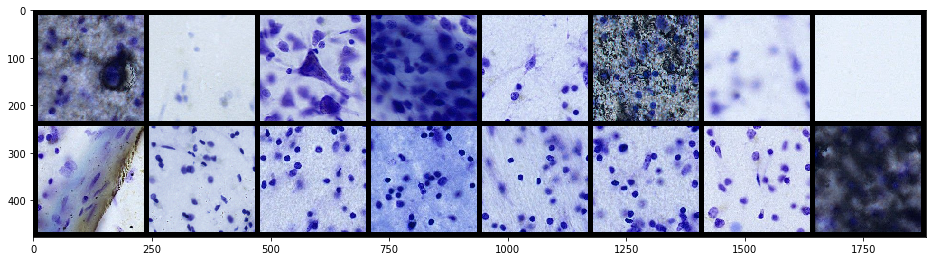

In [15]:
# Read a batch of data again
img,label,paths=next(iter(dl))
img_d = img.to(device)
plt.figure(figsize=(16,16))
show(torchvision.utils.make_grid(img, padding=10, nrow=8, normalize=True))
label.numpy()

In [16]:
# Do a manual forward run of the model
x_clas = model_ft.forward_to_classifier(img_d)
x_cpool = model_ft.spatial_pooling.class_wise(x_clas)
x_spool = model_ft.spatial_pooling.spatial(x_cpool)
x_cpool.shape

torch.Size([16, 2, 112, 112])

Plot below shows the response maps for the object class and background class, respectively

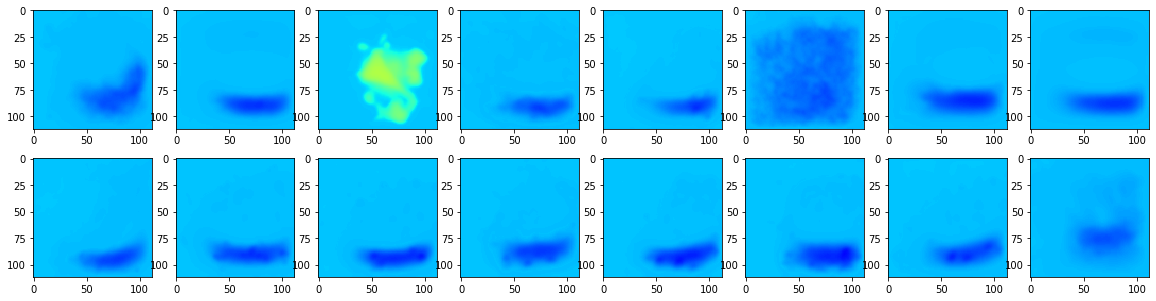

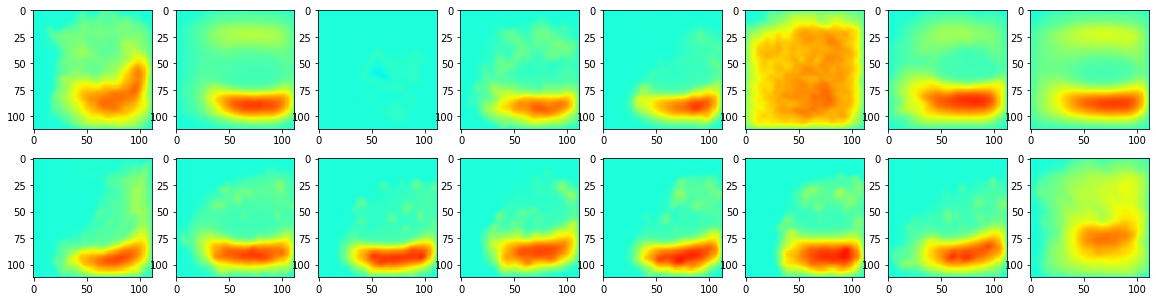

In [17]:
plt.figure(figsize=(20,5))
for i in range(0, batch_size):
    plt.subplot(2, batch_size//2, i + 1)
    plt.imshow(x_cpool[i,1,:,:].cpu().detach().numpy(), vmin=-12, vmax=12, cmap=plt.get_cmap('jet'))
plt.figure(figsize=(20,5))
for i in range(0, batch_size):
    plt.subplot(2, batch_size//2, i + 1)
    plt.imshow(x_cpool[i,0,:,:].cpu().detach().numpy(), vmin=-12, vmax=12, cmap=plt.get_cmap('jet'))

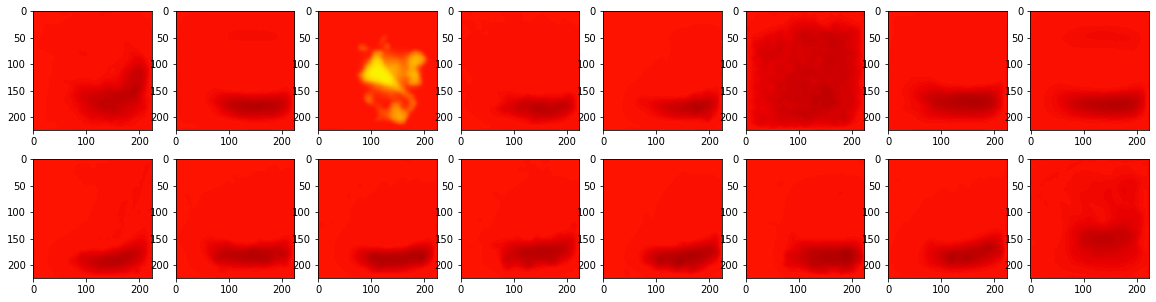

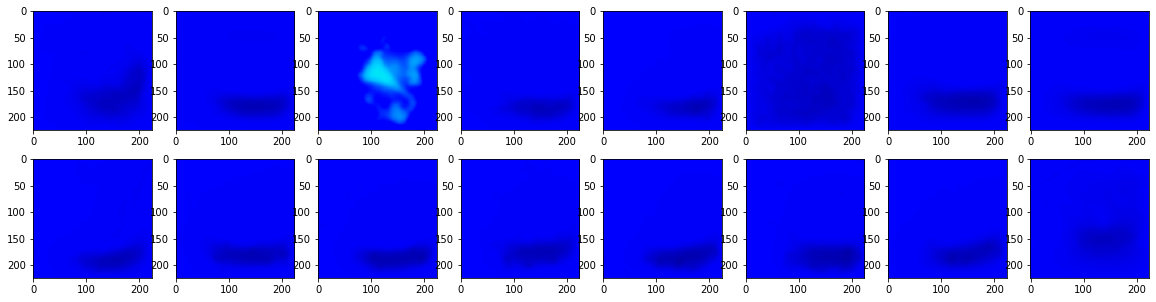

In [18]:
# Upsample the wildcat saliency maps to the image size
unary=nn.functional.interpolate(x_cpool, size=img_d.shape[2:], mode="bilinear", align_corners=False)

# Transform the saliency maps to [0 1] range via sigmoid function
unary[:,1,:,:] = torch.sigmoid((unary[:,1,:,:]-4) / 4.0)
unary[:,0,:,:] = 1 - unary[:,1,:,:];

# Plot the unaries
plt.figure(figsize=(20,5))
for i in range(0, batch_size):
    plt.subplot(2, batch_size//2, i + 1)
    plt.imshow(unary[i,0,:,:].cpu().detach().numpy(), vmin=0, vmax=1, cmap=plt.get_cmap('jet'))
plt.figure(figsize=(20,5))
for i in range(0, batch_size):
    plt.subplot(2, batch_size//2, i + 1)
    plt.imshow(unary[i,1,:,:].cpu().detach().numpy(), vmin=0, vmax=1, cmap=plt.get_cmap('jet'))

